In [1]:
import pandas as pd
from csvCreator import get_readable_date
import numpy as np

In [2]:
def to_evenly_spaced(df):
    df.drop(['phq_2'], axis=1, inplace=True)
    date = df['time'].apply(lambda x: get_readable_date(x))
    df.insert(loc=1, column='date', value=date)
    median = np.trunc(df.groupby('date').size().median())
    df.drop(['date'], axis=1, inplace=True)
    day = np.trunc(len(df.index) / median)
    new_last_index = int(median * day)

    even_time = []
    firs_time = df[['time']].iloc[1].values.item()
    for i in range(len(df.index)):
        even_time.append(firs_time)
        firs_time += 60
    df.drop(['time'], axis=1, inplace=True)
#     df.insert(loc=0, column='time', value=even_time)
    df = df.iloc[:new_last_index]
    return df, int(median)

In [3]:
def generator(data, look_b, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + look_b
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + look_b, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + look_b
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           look_b // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - look_b, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][-1]
        yield samples, targets


In [9]:
output_path = '/Volumes/hex/ST-1441993385-res/'
p = pd.read_csv(output_path + 'ST-1441993385_2.0.csv')

# just numerical data
p = p.drop(['date', 'window'], axis=1)
p, median = to_evenly_spaced(p)

In [10]:
p.head()

,accX,accX_std,accY,accY_std,accZ,accZ_std,gyrX,gyrX_std,gyrY,gyrY_std,...,mood,tense,tired,rumination,socialize,socialize_val,sport_time,work_time,day_sleep,phq_1
0,0.59,4.31,4.59,2.94,6.66,2.94,2.98,82.91,1.87,44.87,...,7,7,5,5,62,65,0,0,0,4
1,-0.35,5.35,0.30,1.40,7.61,1.40,0.58,46.14,0.06,116.84,...,7,7,5,5,62,65,0,0,0,4
2,-1.83,2.06,6.34,1.77,6.55,1.77,0.60,25.90,0.90,30.98,...,7,7,5,5,62,65,0,0,0,4
3,-1.31,1.41,5.96,1.63,7.31,1.63,-0.84,28.71,-0.46,41.61,...,7,7,5,5,62,65,0,0,0,4
4,-1.63,1.24,6.45,1.45,6.76,1.45,-0.47,31.63,-0.36,14.54,...,7,7,5,5,62,65,0,0,0,4


In [11]:
median

744

In [12]:
len(p.index)

189720

In [13]:
float_data = p.to_numpy()

float_data[0]

array([ 5.90000000e-01,  4.31000000e+00,  4.59000000e+00,  2.94000000e+00,
        6.66000000e+00,  2.94000000e+00,  2.98000000e+00,  8.29100000e+01,
        1.87000000e+00,  4.48700000e+01, -3.25000000e+00,  5.50800000e+01,
        8.70500000e+01,  2.80000000e+00,  1.00235000e+03,  1.00000000e-02,
        9.11400000e+01,  6.00000000e-02,  3.35700000e+01,  5.00000000e-02,
        1.00235000e+03,  1.00000000e-02,  2.18011553e+06,  1.29018370e+05,
        0.00000000e+00,  7.00000000e+00,  7.00000000e+00,  5.00000000e+00,
        5.00000000e+00,  6.20000000e+01,  6.50000000e+01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  4.00000000e+00])

In [14]:

# first 185 days as training
mean = float_data[:137640].mean(axis=0)
float_data -= mean
std = float_data[:137640].std(axis=0)
float_data /= std

In [15]:
float_data[0]

array([ 7.93165444e-02,  1.04219675e+00,  1.02186518e+00,  6.22208761e-01,
        1.35824796e+00,  6.22208761e-01,  2.15571064e+00,  1.32455661e+00,
        1.38659723e+00,  1.39090570e+00, -1.57144476e+00,  1.34353937e+00,
       -1.55682693e-01, -2.20902520e-01,  1.30606930e-01, -2.46115392e-01,
       -1.23118531e-01, -1.36514408e-02,  9.98620233e-01,  3.53180911e-01,
        1.30606099e-01, -2.89795534e-01, -7.66586975e-01, -4.63650073e-03,
       -3.53657227e-01, -2.05140616e-01,  4.64242029e-01, -4.92631562e-02,
       -5.23076628e+00,  1.40744469e+00, -5.93641058e-02, -3.16755338e-01,
       -3.54041051e-01, -9.83746350e-01, -7.60918538e-01])

In [30]:
# assume each day got 744 value (average value) that means 17 value per Hour.
# most probably will be 3
# step = 60 / (median / 24)
step = 2
# observations will look back 7 days (average)
look_back = step * 7 * 24
delay = 24 * step

# one day
batch_size = median

In [32]:
batch_size

744

In [33]:
train_gen = generator(float_data,
                      look_b=look_back,
                      delay=delay,
                      min_index=0,
                      max_index=137640,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    look_b=look_back,
                    delay=delay,
                    min_index=137641,
                    max_index=167400,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     look_b=look_back,
                     delay=delay,
                     min_index=167401,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)


In [40]:
test_steps = (len(p.index) - 167401)//batch_size
val_steps = (167400 - 137641)//batch_size
per_epoch =137640//batch_size
per_epoch

185

In [41]:
val_steps

39

In [42]:
test_steps

29

In [43]:
def evaluate_naive_model():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

In [45]:
evaluate_naive_model()

1.3399582575619922


# One GRU layer Model

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

In [48]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimzer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=per_epoch,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)


Train for 185 steps, validate for 39 steps
Epoch 1/20
185/185 [==============================] - 87s 471ms/step - loss: 0.2445 - val_loss: 0.1263
Epoch 2/20
185/185 [==============================] - 83s 447ms/step - loss: 0.1221 - val_loss: 0.1128
Epoch 3/20
185/185 [==============================] - 82s 444ms/step - loss: 0.1091 - val_loss: 0.0987
Epoch 4/20
185/185 [==============================] - 82s 441ms/step - loss: 0.1046 - val_loss: 0.0948
Epoch 5/20
185/185 [==============================] - 82s 445ms/step - loss: 0.1004 - val_loss: 0.0882
Epoch 6/20
185/185 [==============================] - 82s 445ms/step - loss: 0.0991 - val_loss: 0.0828
Epoch 7/20
185/185 [==============================] - 82s 444ms/step - loss: 0.0944 - val_loss: 0.0813
Epoch 8/20
185/185 [==============================] - 85s 461ms/step - loss: 0.0955 - val_loss: 0.0852
Epoch 9/20
185/185 [==============================] - 82s 444ms/step - loss: 0.0936 - val_loss: 0.0891
Epoch 10/20
185/185 [=========

In [49]:
model.save('model_1_385.h5')

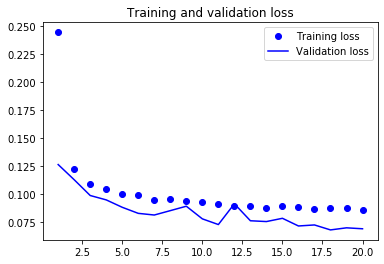

In [51]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [52]:
model.evaluate(test_gen, steps=30)

30/30 [==============================] - 5s 153ms/step - loss: 0.0609


0.06091373264789581

# 1D convenet

In [42]:
model_2 = Sequential()
model_2.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model_2.add(layers.MaxPooling1D(3))
model_2.add(layers.Conv1D(32, 5, activation='relu'))
model_2.add(layers.MaxPooling1D(3))
model_2.add(layers.Conv1D(32, 5, activation='relu'))
model_2.add(layers.GlobalMaxPooling1D())
model_2.add(layers.Dense(1))

model_2.compile(optimizer=RMSprop(), loss='mae')
history_2 = model_2.fit(train_gen,
                        steps_per_epoch=500,
                        epochs=20,
                        validation_data=val_gen,
                        validation_steps=val_steps)

Train for 500 steps, validate for 40.0 steps
Epoch 1/20
500/500 [==============================] - 55s 110ms/step - loss: 0.3315 - val_loss: 0.5216
Epoch 2/20
500/500 [==============================] - 56s 113ms/step - loss: 0.1992 - val_loss: 0.5367
Epoch 3/20
500/500 [==============================] - 52s 103ms/step - loss: 0.1644 - val_loss: 0.5677
Epoch 4/20
500/500 [==============================] - 53s 107ms/step - loss: 0.1420 - val_loss: 0.5722
Epoch 5/20
500/500 [==============================] - 55s 109ms/step - loss: 0.1268 - val_loss: 0.5646
Epoch 6/20
500/500 [==============================] - 58s 116ms/step - loss: 0.1155 - val_loss: 0.5678
Epoch 7/20
500/500 [==============================] - 54s 109ms/step - loss: 0.1068 - val_loss: 0.5746
Epoch 8/20
500/500 [==============================] - 57s 113ms/step - loss: 0.1006 - val_loss: 0.5727
Epoch 9/20
500/500 [==============================] - 55s 110ms/step - loss: 0.0955 - val_loss: 0.5862
Epoch 10/20
500/500 [=======

In [174]:
model_2.save('model_2.h5') 

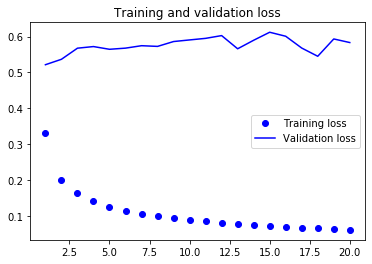

In [175]:
import matplotlib.pyplot as plt
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [187]:
model_2.evaluate(test_gen, steps=30)

30/30 [==============================] - 1s 40ms/step - loss: 0.7885


0.788507649426659

# 1D convnet and GRU model

In [45]:

model_3 = Sequential()
model_3.add(layers.Conv1D(32, 5, activation='relu',
                          input_shape=(None, float_data.shape[-1])))
model_3.add(layers.MaxPooling1D(3))
model_3.add(layers.Conv1D(32, 5, activation='relu'))
model_3.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.3))
model_3.add(layers.Dense(1))

model_3.summary()
model_3.compile(optimizer=RMSprop(), loss='mae')
history_3 = model_3.fit(train_gen,
                        steps_per_epoch=500,
                        epochs=20,
                        validation_data=val_gen,
                        validation_steps=val_steps)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, None, 32)          4192      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_4 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 15,713
Trainable params: 15,713
Non-trainable params: 0
_________________________________________________________________
Train for 500 steps, validate for 40.0 steps
Epoch 1/20
500/500 [==============================] - 115s 230ms/step -

In [177]:
model_3.save('model_3.h5') 

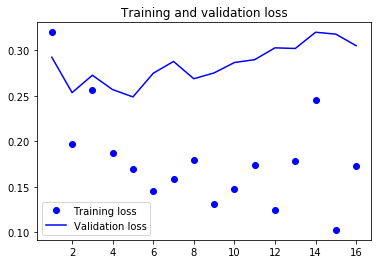

In [51]:
loss = history_3.history['loss'][1:-3]
val_loss = history_3.history['val_loss'][1:-3]

epochs = range(1, len(loss) + 1)
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [186]:
model_3.evaluate(test_gen, steps=30)

30/30 [==============================] - 2s 66ms/step - loss: 0.5556


0.5556494179336975

# One GRU layer with recurrent dropout

In [64]:
model_4 = Sequential()
model_4.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.1,
                     input_shape=(None, float_data.shape[-1])))
model_4.add(layers.Dense(1))

model_4.compile(optimizer=RMSprop(), loss='mae')
history_4 = model_4.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)


Train for 500 steps, validate for 40 steps
Epoch 1/20
500/500 [==============================] - 175s 349ms/step - loss: 2.7620 - val_loss: 0.2623
Epoch 2/20
500/500 [==============================] - 174s 347ms/step - loss: 0.2064 - val_loss: 0.2402
Epoch 3/20
500/500 [==============================] - 173s 345ms/step - loss: 0.1919 - val_loss: 0.2186
Epoch 4/20
500/500 [==============================] - 203s 406ms/step - loss: 0.1967 - val_loss: 0.2198
Epoch 5/20
500/500 [==============================] - 177s 353ms/step - loss: 0.2820 - val_loss: 0.2258
Epoch 6/20
500/500 [==============================] - 179s 359ms/step - loss: 0.3132 - val_loss: 0.2149
Epoch 7/20
500/500 [==============================] - 194s 388ms/step - loss: 0.2561 - val_loss: 0.2122
Epoch 8/20
500/500 [==============================] - 193s 387ms/step - loss: 0.6875 - val_loss: 0.2263
Epoch 9/20
500/500 [==============================] - 195s 389ms/step - loss: 0.2115 - val_loss: 0.2200
Epoch 10/20
500/500 [

In [179]:
model_4.save('model_4.h5') 

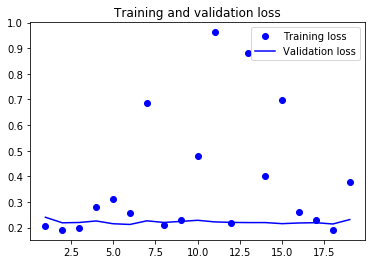

In [74]:
loss = history_4.history['loss'][1:]
val_loss = history_4.history['val_loss'][1:]

epochs = range(1, len(loss) + 1)
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [185]:
model_4.evaluate(test_gen, steps=30)

30/30 [==============================] - 3s 89ms/step - loss: 0.3007


0.30071445753177006

In [72]:
model_5 = Sequential()
model_5.add(layers.Conv1D(64, 5, activation='relu',
                          input_shape=(None, float_data.shape[-1])))
model_5.add(layers.MaxPooling1D(3))
model_5.add(layers.Conv1D(64, 5, activation='relu'))
model_5.add(layers.GRU(64, dropout=0.1, recurrent_dropout=0.2))
model_5.add(layers.Dense(1))

model_5.summary()
model_5.compile(optimizer=RMSprop(), loss='mae')
history_5 = model_5.fit(train_gen,
                        steps_per_epoch=500,
                        epochs=20,
                        validation_data=val_gen,
                        validation_steps=val_steps)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, None, 64)          8384      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 64)          20544     
_________________________________________________________________
gru_12 (GRU)                 (None, 64)                24960     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 53,953
Trainable params: 53,953
Non-trainable params: 0
_________________________________________________________________
Train for 500 steps, validate for 40.0 steps
Epoch 1/20
500/500 [==============================] - 182s 365ms/step 

In [181]:
model_5.save('model_5.h5') 

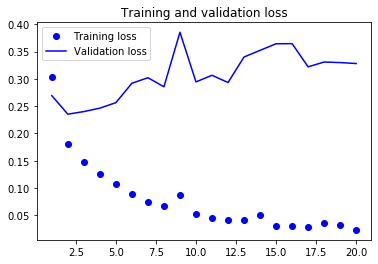

In [182]:
loss = history_5.history['loss']
val_loss = history_5.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [184]:
model_5.evaluate(test_gen, steps=30)

30/30 [==============================] - 3s 96ms/step - loss: 0.5721


0.5721043894377847

In [ ]:
model_6 = Sequential()
model_6.add(layers.LSTM(10,input_shape=(None, float_data.shape[-1])))
model_6.add(layers.Dense(1, activation='linear'))

model_6.summary()
model_6.compile(optimizer='adam', loss='mse')
history_6 = model_6.fit(train_gen,
                        steps_per_epoch=per_epoch,
                        epochs=20,
                        validation_data=val_gen,
                        validation_steps=val_steps)